In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pprint import pprint
from itertools import combinations, cycle, islice
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, FeatureAgglomeration
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [2]:
from metagov import cryptopolitics
from metagov.cryptopolitics import SAVEDIR, QUESTIONS, COLS_QUESTIONS, COLS_RESULTS, FACTION_ORDERS, n2q

In [3]:
SAVEFIG = False
fig_ext = '.png'
fig_kwargs = cryptopolitics.KWARGS_PNG

politics: ['Crypto-leftist', 'DAOist', 'True neutral', 'Crypto-libertarian', 'Crypto-ancap']
economics: ['Earner', 'Cryptopunk', 'NPC', 'Techtrepreneur', 'Degen']
governance: ['Walchian', 'Zamfirist', 'Noob', 'Gavinist', 'Szabian']


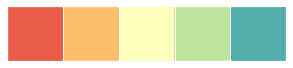

In [4]:
# In case a lot of clusters are found
COLORS = np.array(sns.color_palette('bright').as_hex() + \
                  sns.color_palette('pastel').as_hex() + \
                  sns.color_palette('dark').as_hex() + \
                  sns.color_palette('muted').as_hex())
FIVE_COLORS = sns.color_palette("Spectral", 5)
COLORS_MIN = np.array(FIVE_COLORS.as_hex())
sns.palplot(FIVE_COLORS)
for k, v in FACTION_ORDERS.items():
    print(f"{k}: {v}")

# Cryptopolitical Typology Quiz analysis - dimensionality reduction and factor analysis

The [Cryptopolitical Typology Quiz](https://metagov.typeform.com/cryptopolitics) was developed by the [Metagovernance Project](https://metagov.org/) to help the crypto community understand its political, economic, and governance beliefs. Survey results were collected from September 27, 2021 through March 4, 2022 and have been published on the [Govbase Airtable database](https://airtable.com/shr9LYMni8pBUVD6q/tblvwbt4KFm8MOSUQ). 

In [5]:
data = cryptopolitics.load_data()
df_questions, df_results = data.values()

## Method
We built the initial set of factions by hand, but we were curious whether these or factions and features might arise naturally from the data. To look for these, we used feature selection methods (e.g. PCA, feature agglomeration). The hope was to identify and describe groupings of questions in a meaningful way. We might hope to find axes that correspond to something like the "politics" or "economics" axes defined in the survey, or some other belief/value axis not yet identified. These would allow us to view the data as projected onto these axes.

Steps involved:
- **Preprocessing** (how to encode the data)
- **Principal component analysis (PCA)** as a feature selection method
    - Which choices contribute the most to the components which explain the most variance between respondents?
    - Do the assigned factions or classes directly correlate with any of the first few components? (I.e., are any of the "axes" we defined parallel to any of the first few principal component vectors?)
- **Feature agglomeration** as a factor analyis method
    - Which choices, when grouped together, may reflect a latent variable that describes respondents' beliefs?
    - Do the assigned factions or classes directly correlate with any of the identified factors? (I.e., to what extend does our categorization of beliefs as political, economic, or governance-related meaningfully describe joint variations in the choices selected?)

An alternative method that could be relevant here is multiple correspondence analysis.

General process notes:
- For many clustering methods, the **distance** or **affinity** metric chosen greatly affects the resulting fit. Since ultimately this data is categorical, wherever there was the option, "manhattan" (cityblock) distance was chosen.

## Preprocessing
- Drop questions relating to specific ecosystems (Q2, Q19)
- Drop rows with any unanswered questions. We choose not to code the null response as a separate choice given how infrequently it was chosen.
- One-hot encode the individual choices (49 columns)
- Apply the standard scaler (shift mean to 0 and scale to unit variance). Note that since the data is one-hot encoded, the variance is directly related to the percentage of respondents who 

In [6]:
COLS_QUESTIONS_clustering = COLS_QUESTIONS.copy()
COLS_QUESTIONS_clustering.remove('Q2')
COLS_QUESTIONS_clustering.remove('Q19')

In [7]:
df_tmp = df_questions.copy().drop(columns=['Q2', 'Q19'])
len_orig = len(df_tmp.index)
df_to_cluster = df_tmp.dropna()
len_new = len(df_to_cluster.index)
print(f"Using {len_new} respondents (dropped {len_orig - len_new} rows with unanswered questions)")
df_result_to_cluster = df_results.loc[df_to_cluster.index, :]

Using 3418 respondents (dropped 292 rows with unanswered questions)


In [8]:
def get_color(faction):
    return list(df_result_to_cluster[faction].apply(lambda x: COLORS_MIN[FACTION_ORDERS[faction].index(x)]))

colors_pol = get_color('politics')
colors_econ = get_color('economics')
colors_gov = get_color('governance')

#### Categorical encoding (one-hot) and standard scaling (mean = 0 and unit variance)

In [9]:
# Encode all questions as one-hot (only categorical data)
v = DictVectorizer(sparse=False)
X_allCat = v.fit_transform(df_to_cluster.to_dict(orient='records'))
feature_names = v.get_feature_names_out()

#To reduce multicollinearity:
#feature_names = [name for name in v.get_feature_names_out() if NO_ANSWER not in name]
#X_allCat = np.array([X_allCat[:,i] for i, fn in enumerate(feature_names)]).transpose()

# Scale
X_allCat = StandardScaler().fit_transform(X_allCat)
df_allCat = pd.DataFrame(X_allCat, columns=feature_names)

df_allCat.shape

(3418, 48)

## PCA

### Setup

In [10]:
def scatter_plot_combos(X, N, colors=None, title=''):
    """Given X with shape (n_samples, n_dimensions) where n_dimensions may be >2,
    plot each combination of dimensions as a 2D scatter plot, with colors optionally specified"""
    
    color = cryptopolitics.DEFAULT_COLOR
    if colors is not None:
        color = colors
    if title != '':
        title = title + ': '
    
    for combo in list(combinations(list(range(N)), 2)):
        plt.figure()
        plt.scatter(X[:,combo[0]], X[:,combo[1]], color=color, alpha=0.25)
        plt.xlabel(combo[0])
        plt.ylabel(combo[1])
        plt.title(f"{title}n_components = {N} {combo}")

In [11]:
def mean_plot_combos(X, N, colors, category=None, title=''):
    # Group X by color (i.e., faction)
    
    assert category in ['politics', 'economics', 'governance'], "Choose a faction/class group"
    
    valuesList = []
    for component in range(N):
        X_component = X[:, component]
        for index, c in enumerate(COLORS_MIN):
            faction = FACTION_ORDERS[category][index]
            X_faction = [x for i, x in enumerate(X_component) if colors[i] == c]
            for x in X_faction:
                valuesList.append(pd.Series(
                    {'value': x, 'component': component, 'faction': faction}))
        df_plot = pd.concat(valuesList, ignore_index=True, axis=1).transpose()

    plt.figure()
    palette = FIVE_COLORS
    if category == 'governance' and len(df_plot['faction'].unique()) == 4:
        palette = [c for i, c in enumerate(FIVE_COLORS) if i != 2] # No "Noob" category
    ax = sns.boxplot(x='component', y='value', data=df_plot, hue='faction', 
                palette=palette, fliersize=0)
    sns.move_legend(ax, "center left", bbox_to_anchor=(1.05, .50))

In [12]:
def compute_pca(X, N, labels=None):
    """Compute and plot PCA transformation of data"""
    
    # Transform
    pca = PCA(n_components=N)
    X_transformed = pca.fit_transform(X)

    print(f"Total variance explained by {N} components: {100*sum(pca.explained_variance_ratio_):.1f}%")
    print(f"Total variance explained by 3 components: {100*sum(pca.explained_variance_ratio_[:3]):.1f}%")   
    
    # Display PCA vectors against one another
    df_tmp = pd.DataFrame(np.transpose(pca.components_))
    if labels is not None:
        df_tmp.index = labels
    if len(df_tmp.columns) > 3:
        df_tmp = df_tmp.iloc[:, :3]
    df_tmp.plot.bar(width=0.85, figsize=(18,6))
    plt.ylabel('Component value')
    
    # Find most relevant choices
    threshold = 0.15
    print(f"With threshold of magnitude >= {threshold}:")
    for comp in [0,1,2]:
        features = pca.components_[comp,:]
        features_enum = [(i,f) for i,f in enumerate(features)]
        features_sorted = sorted(features_enum, reverse=True, key=(lambda x: abs(x[1])))
        cumsum = 0
        print(f"\nComponent {comp}")
        print("Mag.\tCum.\tFeature")
        for i in range(len(features)):
            feature = features_sorted[i]
            if abs(feature[1]) < threshold:
                break
            cumsum = np.sqrt(feature[1]**2 + cumsum**2)
            print(f"{feature[1]:.2f}\t{cumsum:.2f}\t{labels[feature[0]]}")
    
    if SAVEFIG:
        df_tmp.to_csv(f"{SAVEDIR}/cryptopolitics_pca.csv")
    
    # Scree plot
    plt.figure()
    plt.plot(np.arange(pca.n_components_) + 1, 100*pca.explained_variance_ratio_,
                'o-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.show()

    return X_transformed, pca

### Analysis

In [13]:
n_PCA = 17 # Number of questions included in this analysis
nComponents = 3 # Number of components we care about

Total variance explained by 17 components: 69.7%
Total variance explained by 3 components: 20.8%
With threshold of magnitude >= 0.15:

Component 0
Mag.	Cum.	Feature
0.29	0.29	Q12=The economic system in crypto unfairly favors powerful interests.
-0.29	0.41	Q12=The economic system in crypto is generally fair to most of its participants.
-0.27	0.49	Q15=Crypto does not have a gender problem.
0.27	0.56	Q15=Crypto has a gender problem.
-0.24	0.61	Q7=Government regulation of crypto will almost always do more harm than good.
0.23	0.65	Q18=Liberal or left-wing
0.20	0.68	Q11=Crypto teams make too much profit.
-0.20	0.71	Q11=Most crypto teams make a fair and reasonable amount of profit.
0.19	0.74	Q13=In crypto, hard work and determination are no guarantee of success for most people.
-0.19	0.76	Q13=Most people who want to get ahead in crypto can make it if they're willing to work hard.
0.19	0.79	Q5=However crypto governs itself, it should also be regulated by the government.
0.18	0.81	Q10=Blockcha

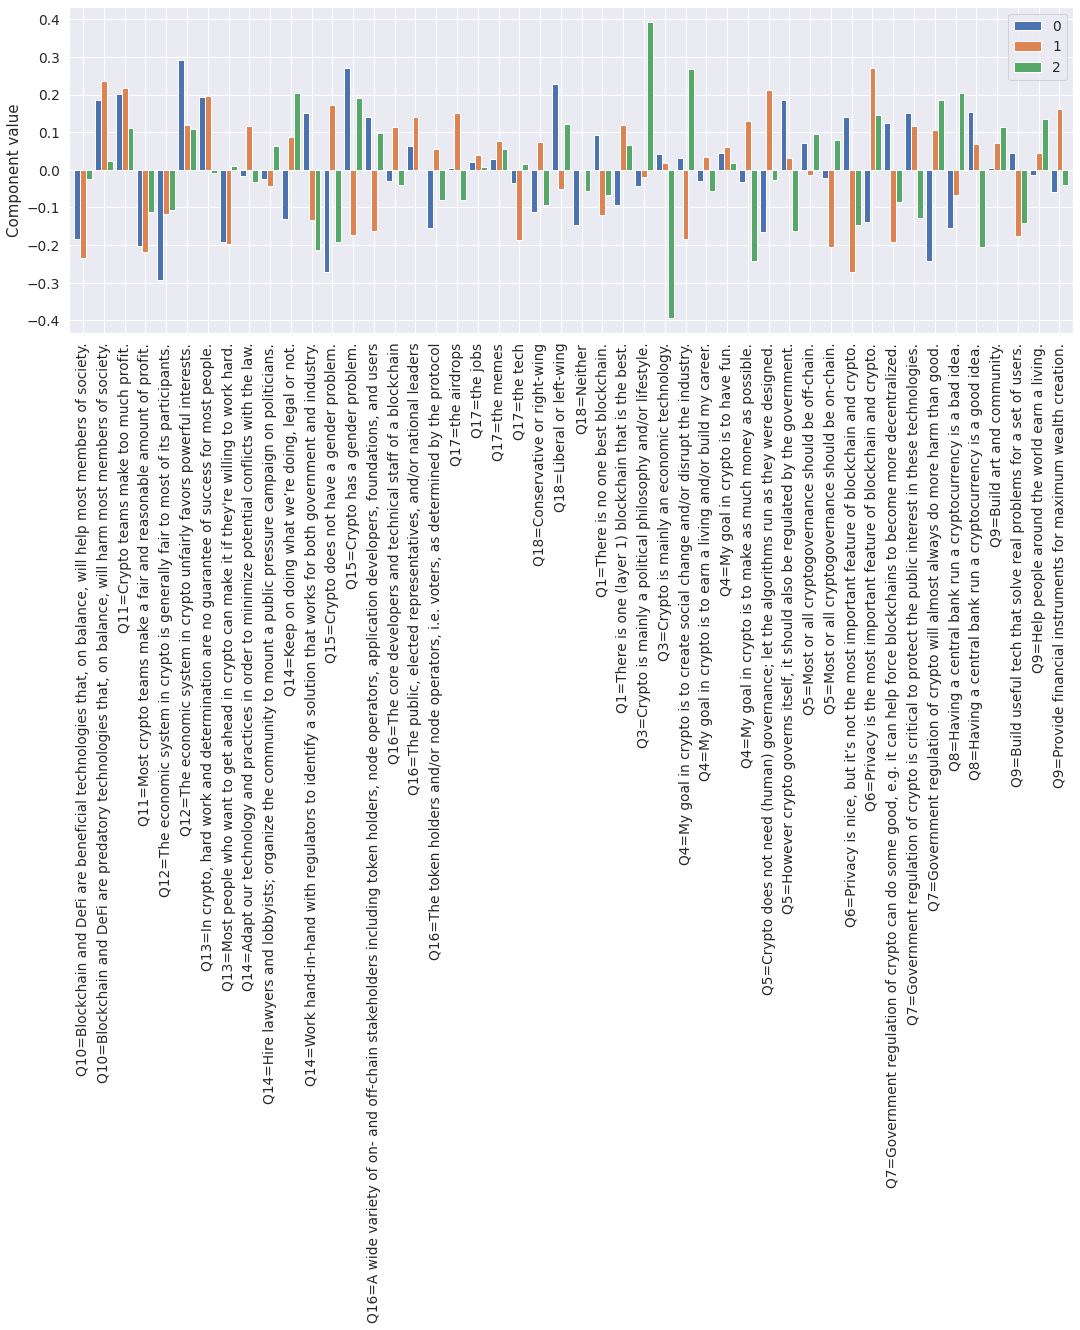

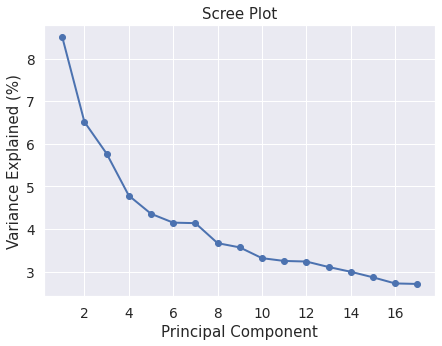

In [14]:
# Plot with political faction colors
X_pca, pca_result = compute_pca(X_allCat, n_PCA, 
                                labels=list(df_allCat.columns))

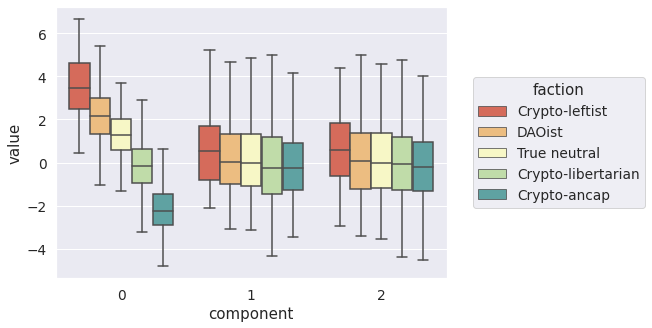

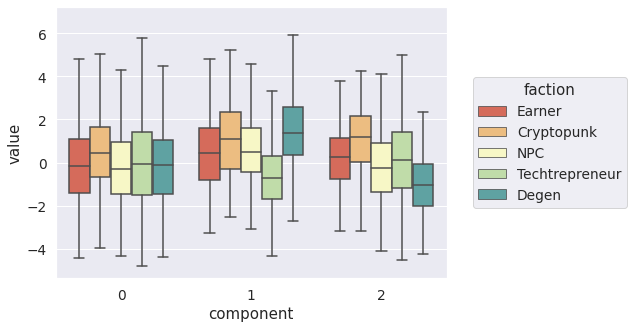

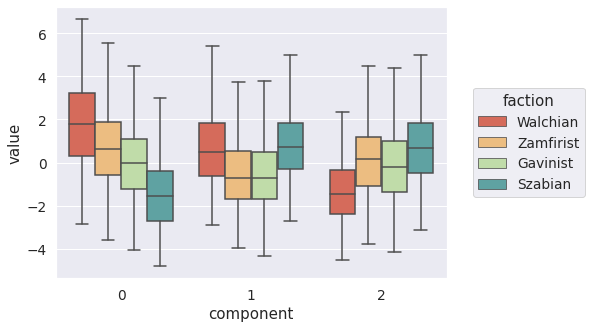

In [15]:
mean_plot_combos(X_pca, nComponents, colors_pol, category='politics')
mean_plot_combos(X_pca, nComponents, colors_econ, category='economics')
mean_plot_combos(X_pca, nComponents, colors_gov, category='governance')

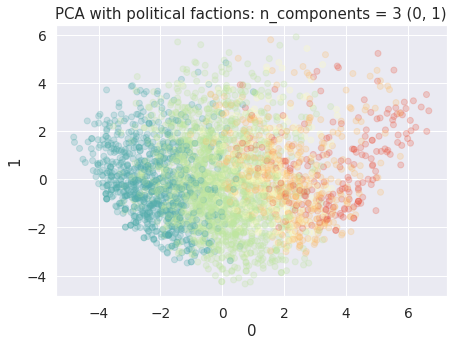

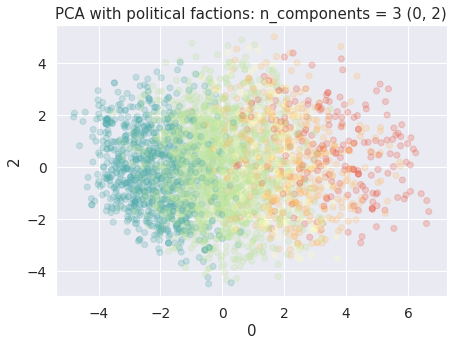

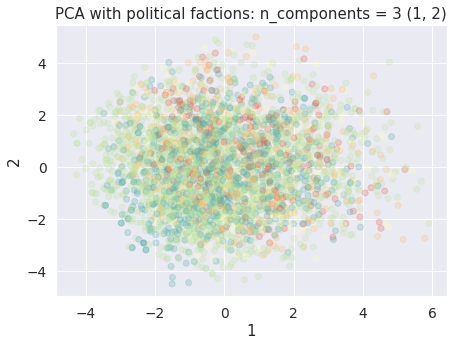

In [16]:
# Plot with political faction colors
scatter_plot_combos(X_pca, 3, title='PCA with political factions', colors=colors_pol)

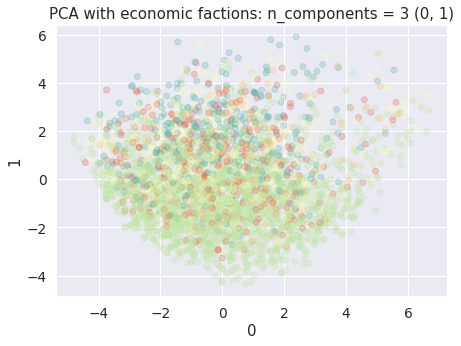

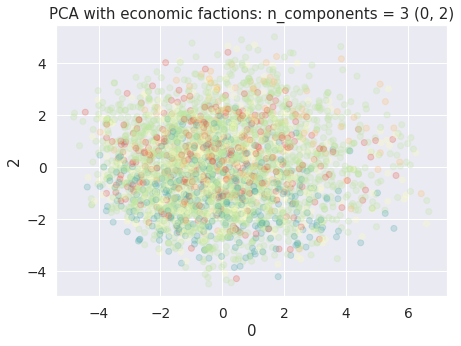

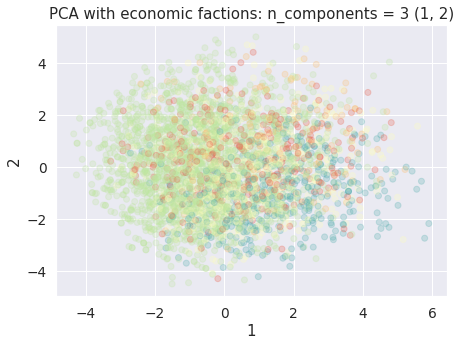

In [17]:
# Plot with economic faction colors
scatter_plot_combos(X_pca, 3, title='PCA with economic factions', colors=colors_econ)

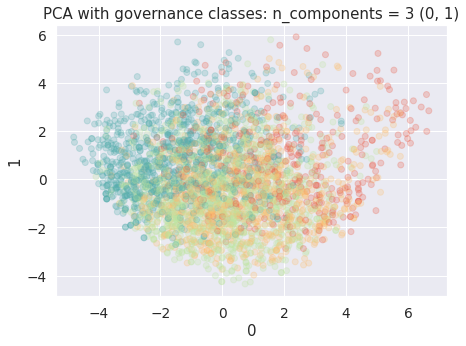

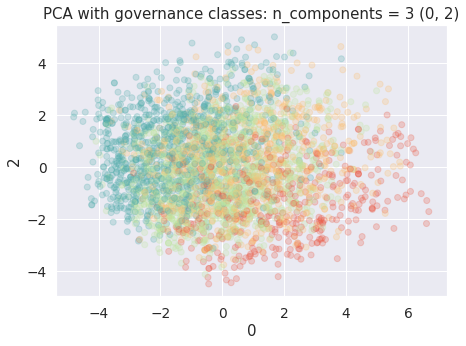

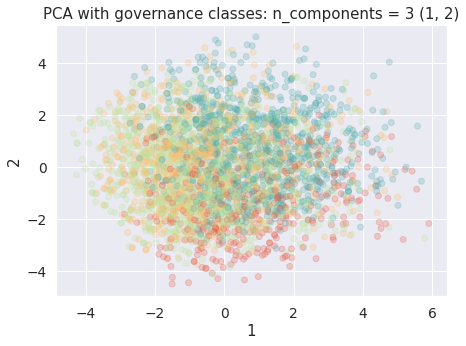

In [18]:
# Plot with governance class colors
scatter_plot_combos(X_pca, 3, title='PCA with governance classes', colors=colors_gov)

## Feature agglomeration

### Setup

In [19]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and plot the dendrogram
    
    Copied from scikit-learn example:
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    """

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis)")

In [20]:
def compute_feature_agglomeration(X, N, labels=None, kwargs={}):
    """Compute and plot feature agglomeration transformation of data
    
    Choice of distance metric is very important!"""
    
    # Transform
    fa = FeatureAgglomeration(n_clusters=N, compute_distances=True, **kwargs) #cosine, cityblock, hamming, dice
    X_transformed = fa.fit_transform(X)

    # Display some results
    if labels is not None:
        features = pd.DataFrame([{'question': labels[i], 'feature': x} for (i, x) in enumerate(fa.labels_)])
        gb = features.groupby(by='feature')
        for key, item in gb:
            print(f"feature {key}")
            print(" ", "\n  ".join(gb.get_group(key)['question'].values), "\n")

    # Plot dendrogram of connections between clusters
    plt.figure()
    plot_dendrogram(fa, truncate_mode="lastp", p=N)
    
    return X_transformed, fa

### Analysis

In [21]:
kwargs_fa = {'affinity': 'manhattan', 'linkage': 'complete'}
nFeatures = 3
nQuestions = 17

feature 0
  Q14=Keep on doing what we’re doing, legal or not.
  Q4=My goal in crypto is to make as much money as possible.
  Q5=Crypto does not need (human) governance; let the algorithms run as they were designed.
  Q6=Privacy is the most important feature of blockchain and crypto. 

feature 1
  Q11=Crypto teams make too much profit.
  Q12=The economic system in crypto unfairly favors powerful interests.
  Q13=In crypto, hard work and determination are no guarantee of success for most people. 

feature 2
  Q11=Most crypto teams make a fair and reasonable amount of profit.
  Q12=The economic system in crypto is generally fair to most of its participants.
  Q13=Most people who want to get ahead in crypto can make it if they're willing to work hard. 

feature 3
  Q5=Most or all cryptogovernance should be on-chain.
  Q7=Government regulation of crypto can do some good, e.g. it can help force blockchains to become more decentralized. 

feature 4
  Q6=Privacy is nice, but it’s not the most 

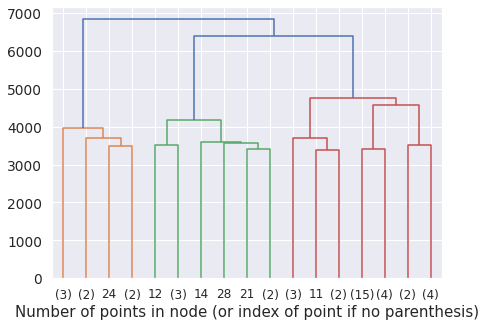

In [22]:
# Feature agglomeration on categorical data - 17 features
X_fa_all, fa_result_allCat = compute_feature_agglomeration(X_allCat, nQuestions,
                                                              labels=df_allCat.columns,
                                                              kwargs=kwargs_fa)

feature 0
  Q10=Blockchain and DeFi are predatory technologies that, on balance, will harm most members of society.
  Q11=Crypto teams make too much profit.
  Q12=The economic system in crypto unfairly favors powerful interests.
  Q13=In crypto, hard work and determination are no guarantee of success for most people.
  Q14=Adapt our technology and practices in order to minimize potential conflicts with the law.
  Q14=Hire lawyers and lobbyists; organize the community to mount a public pressure campaign on politicians.
  Q14=Keep on doing what we’re doing, legal or not.
  Q14=Work hand-in-hand with regulators to identify a solution that works for both government and industry.
  Q15=Crypto has a gender problem.
  Q16=The core developers and technical staff of a blockchain
  Q16=The public, elected representatives, and/or national leaders
  Q16=The token holders and/or node operators, i.e. voters, as determined by the protocol
  Q17=the airdrops
  Q17=the jobs
  Q17=the memes
  Q18=Conser

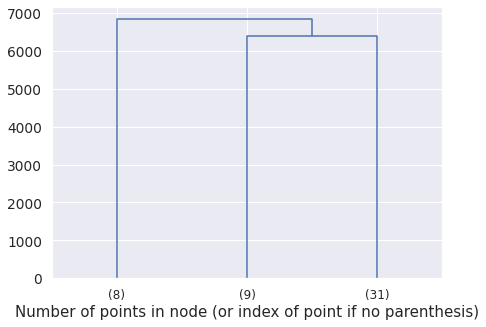

In [23]:
# Feature agglomeration on categorical data - 4 features
X_fa, fa_result_allCat = compute_feature_agglomeration(X_allCat, nFeatures,
                                                              labels=df_allCat.columns,
                                                              kwargs=kwargs_fa)

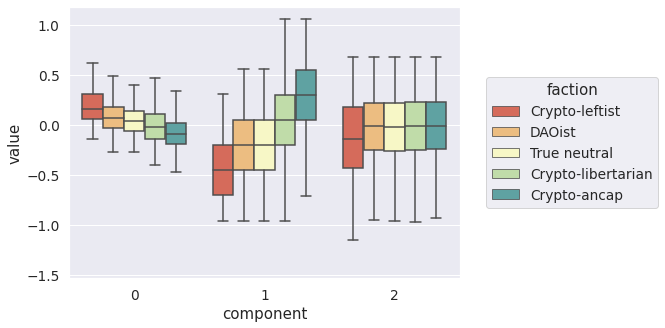

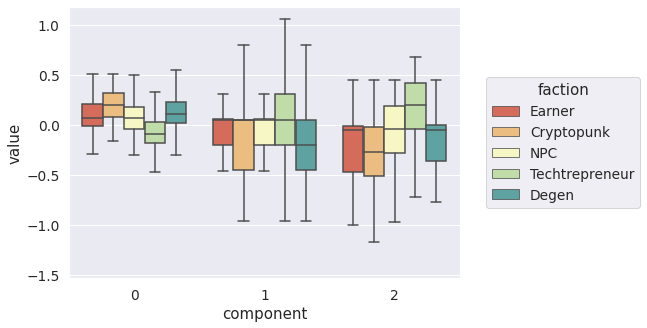

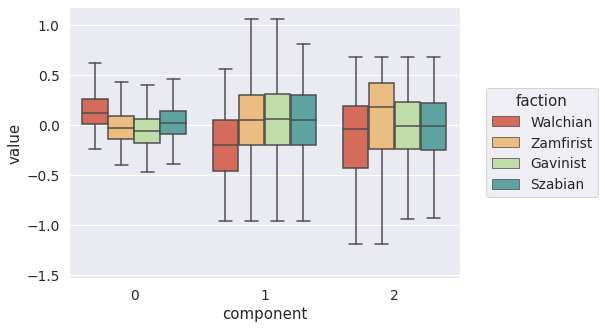

In [24]:
mean_plot_combos(X_fa, nFeatures, colors_pol, category='politics')
mean_plot_combos(X_fa, nFeatures, colors_econ, category='economics')
mean_plot_combos(X_fa, nFeatures, colors_gov, category='governance')

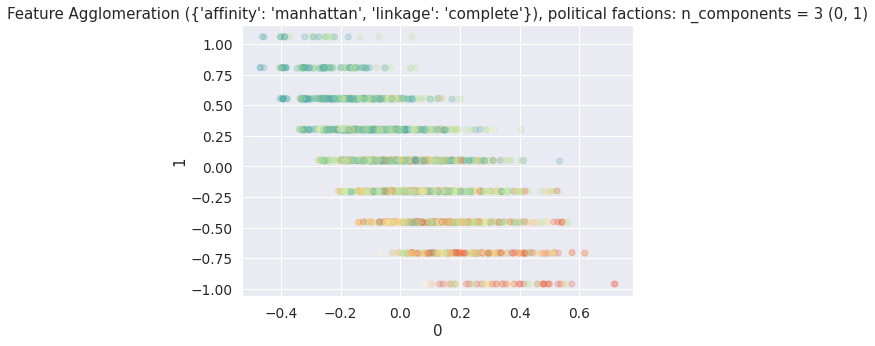

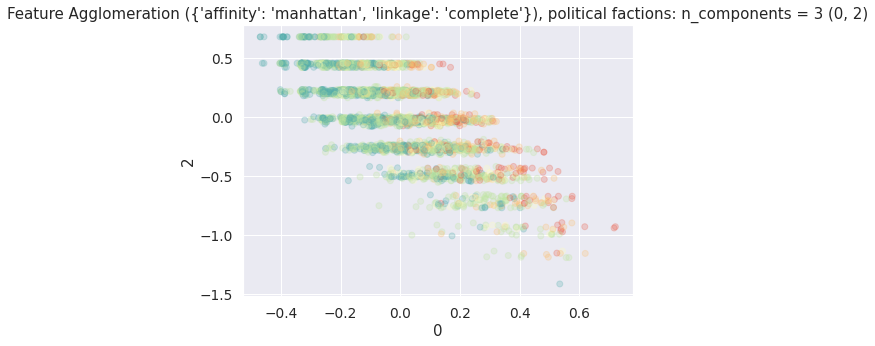

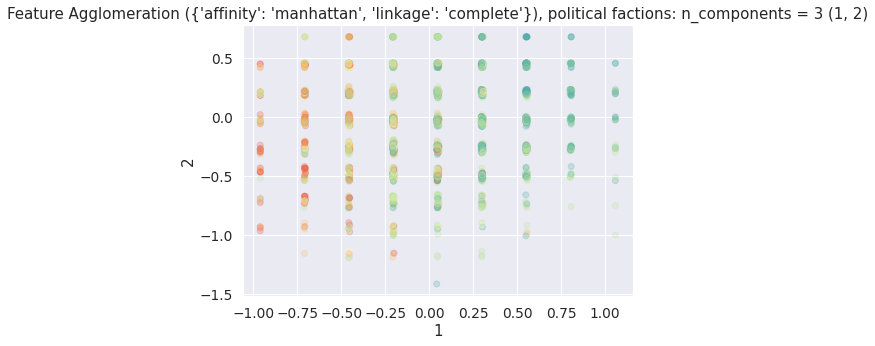

In [25]:
# Plot with political faction colors
scatter_plot_combos(X_fa,
                    nFeatures,
                    title=f"Feature Agglomeration ({kwargs_fa}), political factions",
                    colors=colors_pol)

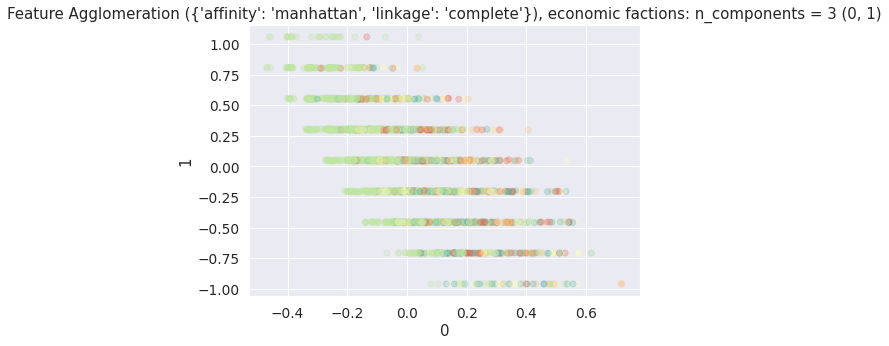

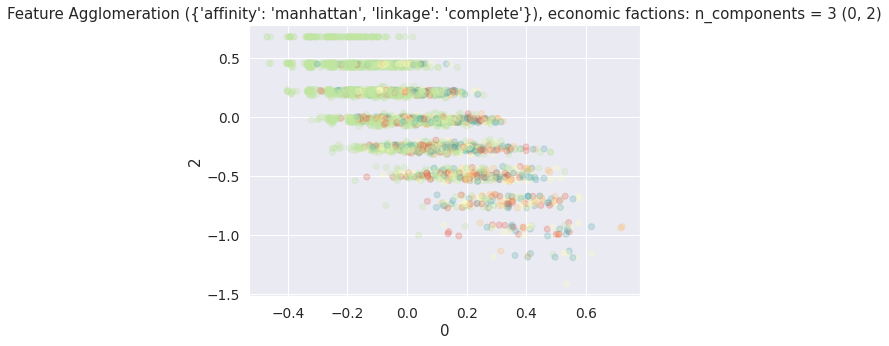

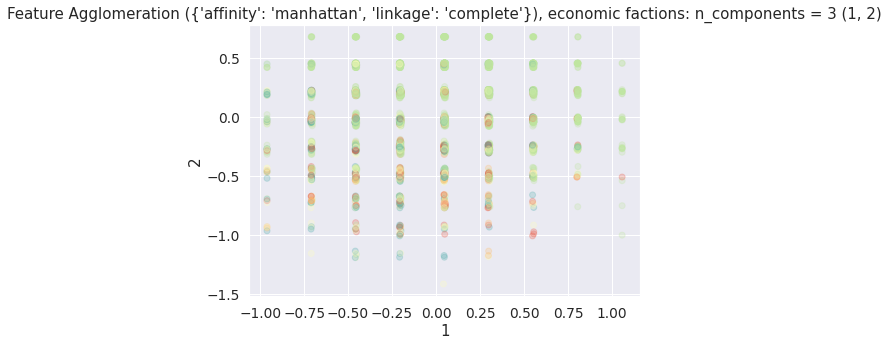

In [26]:
# Plot with economic faction colors
scatter_plot_combos(X_fa,
                    nFeatures,
                    title=f"Feature Agglomeration ({kwargs_fa}), economic factions",
                    colors=colors_econ)

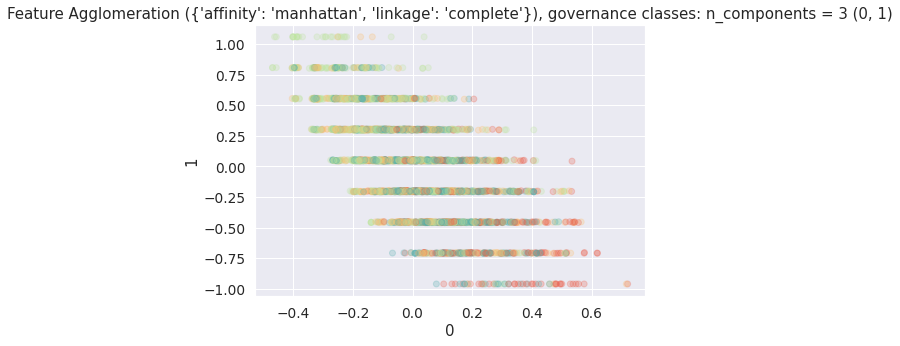

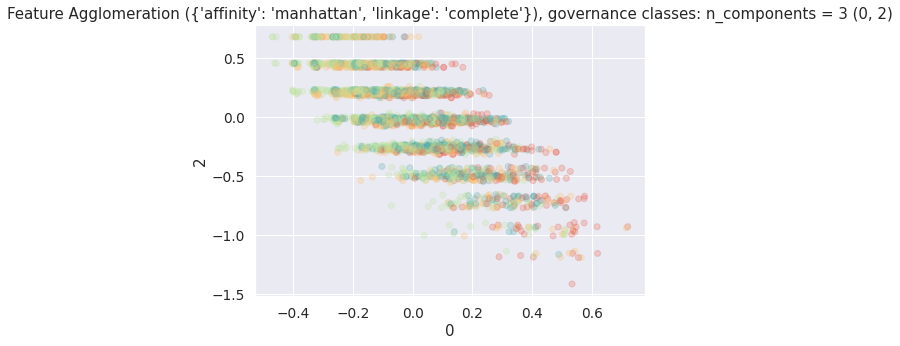

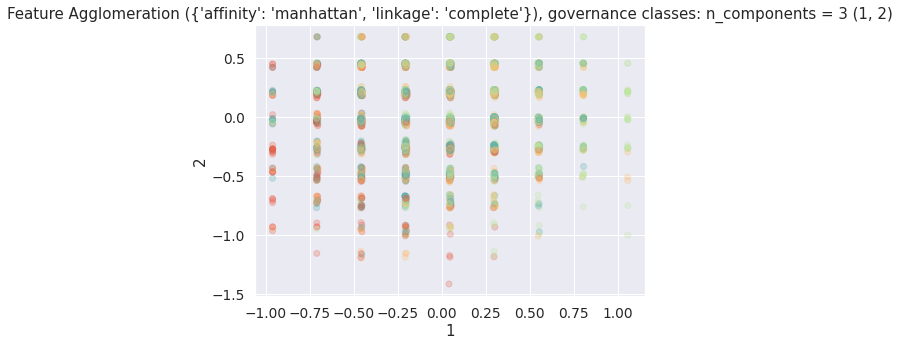

In [27]:
# Plot with governance class colors
scatter_plot_combos(X_fa,
                    nFeatures,
                    title=f"Feature Agglomeration ({kwargs_fa}), governance classes",
                    colors=colors_gov)